In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



In [3]:
# Đọc file
df = pd.read_csv("META.csv")
df.head()

,Date,Open,High,Low,Close,Volume
0,18-05-12,41.889986,44.828761,37.855398,38.084522,573576400
1,21-05-12,36.390988,36.520494,32.874422,33.900501,168192700
2,22-05-12,32.485908,33.462179,30.822263,30.882034,101786600
3,23-05-12,31.250625,32.376325,31.240663,31.878227,73600000
4,24-05-12,32.824611,33.083620,31.649101,32.904305,50237200


In [4]:
# Chuyển 'Date' thành datetime và set làm index
df['Date'] = pd.to_datetime(df['Date'],format='%d-%m-%y')
df.set_index('Date', inplace=True)


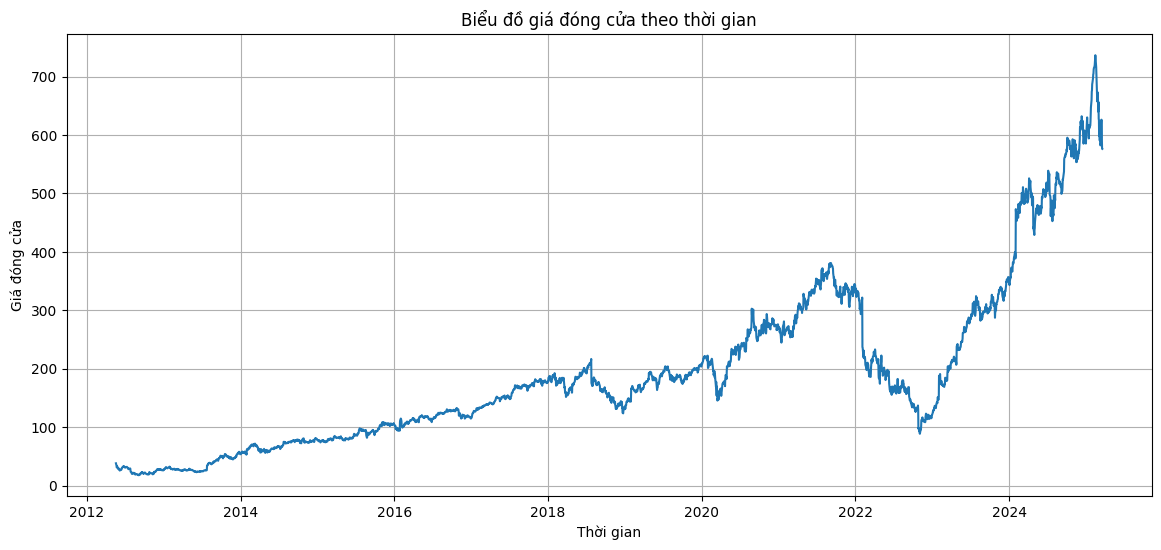

In [5]:
# Lấy cột 'Close'
df_close = df['Close']

# Vẽ biểu đồ
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_close)
plt.title('Biểu đồ giá đóng cửa theo thời gian')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa')
plt.grid(True)
plt.show()



In [6]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries, title="Chuỗi"):
    print(f"\n=== ADF Test: {title} ===")
    result = adfuller(timeseries)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    for key, value in result[4].items():
        print(f"Critical Value ({key}): {value}")
    if result[1] <= 0.05:
        print("Chuỗi có tính dừng (reject H0)")
    else:
        print("Chuỗi KHÔNG có tính dừng (fail to reject H0)")

# Kiểm tra chuỗi gốc
check_stationarity(df_close, "Giá đóng cửa gốc")


=== ADF Test: Giá đóng cửa gốc ===
ADF Statistic: 0.3499242353268368
p-value: 0.9795225487191122
Critical Value (1%): -3.4323793062321144
Critical Value (5%): -2.8624366253389106
Critical Value (10%): -2.567247293335737
Chuỗi KHÔNG có tính dừng (fail to reject H0)


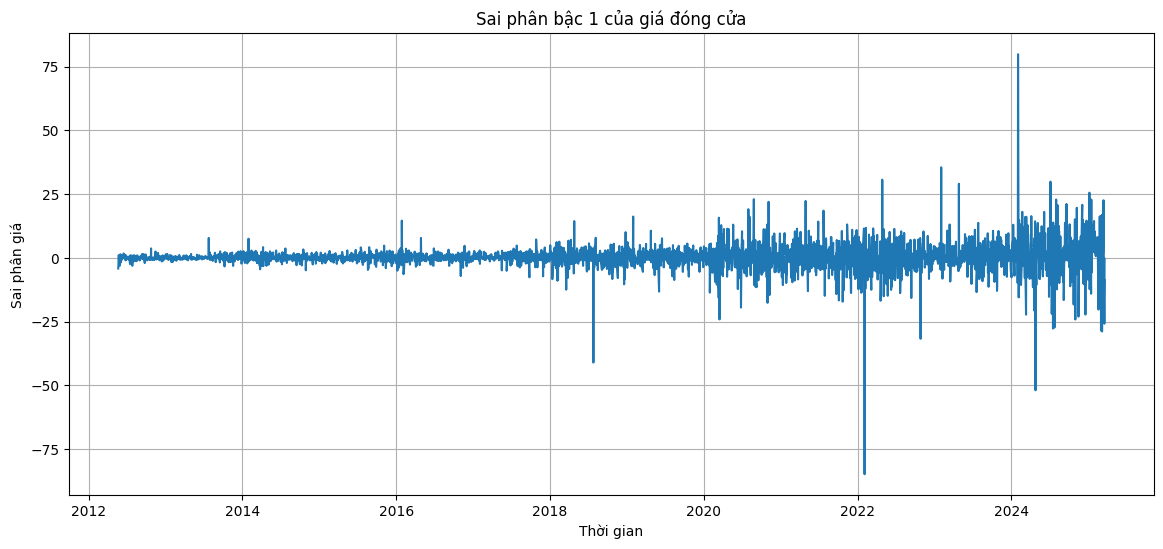

In [7]:
# Tính sai phân
df_diff = df_close.diff().dropna()

# Vẽ biểu đồ sai phân
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_diff)
plt.title('Sai phân bậc 1 của giá đóng cửa')
plt.xlabel('Thời gian')
plt.ylabel('Sai phân giá')
plt.grid(True)
plt.show()



In [8]:
# Kiểm tra tính dừng sau sai phân
check_stationarity(df_diff, "Sai phân bậc 1")


=== ADF Test: Sai phân bậc 1 ===
ADF Statistic: -18.13820220035674
p-value: 2.4950878319854807e-30
Critical Value (1%): -3.4323793062321144
Critical Value (5%): -2.8624366253389106
Critical Value (10%): -2.567247293335737
Chuỗi có tính dừng (reject H0)


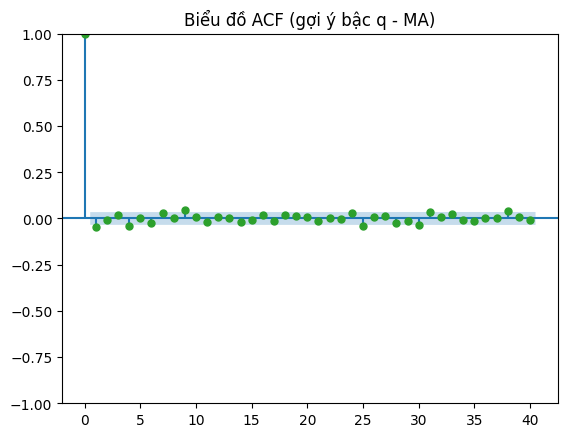

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

series = df_diff

# Vẽ ACF và PACF
plt.plot(1, 2, 1)
plot_acf(series, ax=plt.gca(), lags=40)
plt.title("Biểu đồ ACF (gợi ý bậc q - MA)")

# plt.plot(1, 2, 2)
# plot_pacf(series, ax=plt.gca(), lags=40, method='ywm')
# plt.title("Biểu đồ PACF (gợi ý bậc p - AR)")

# plt.tight_layout()
plt.show()


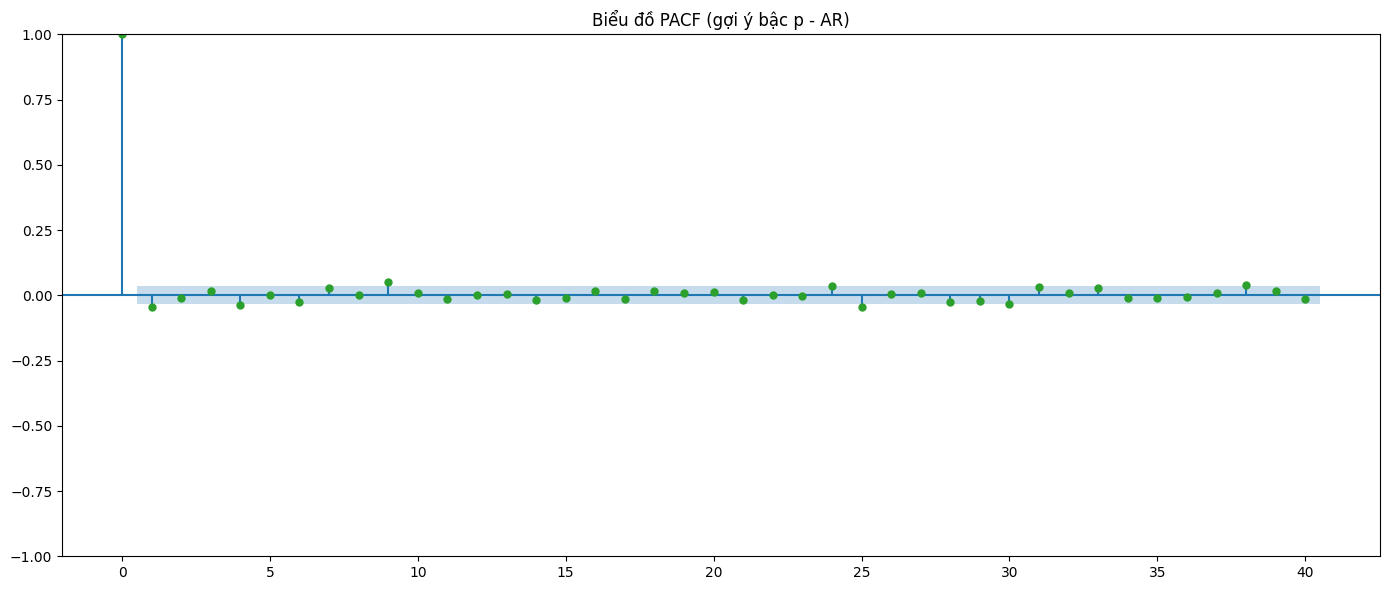

In [13]:
plt.figure(figsize=(14,6))
plt.plot(1, 2, 2)
plot_pacf(series, ax=plt.gca(), lags=40, method='ywm')
plt.title("Biểu đồ PACF (gợi ý bậc p - AR)")

plt.tight_layout()
plt.show()


In [16]:
# Sử dụng lại chuỗi gốc 'Close' chưa sai phân
data = df['Close'].copy()

# Chia 80% train, 20% test
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

print(f"Train: {len(train)} mẫu, Test: {len(test)} mẫu")


Train: 2588 mẫu, Test: 647 mẫu


In [55]:
# Xây dựng mô hình ARIMA
model = ARIMA(train, order=(1, 1, 1)) 
model_fit = model.fit()

# In summary mô hình
print(model_fit.summary())


c:\Users\nhiye\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nhiye\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nhiye\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7313.370
Date:                Fri, 25 Apr 2025   AIC                          14632.739
Time:                        13:58:55   BIC                          14650.314
Sample:                             0   HQIC                         14639.109
                               - 2588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5611      0.130     -4.332      0.000      -0.815      -0.307
ma.L1          0.5088      0.136      3.751      0.000       0.243       0.775
sigma2        16.7111      0.075    223.355      0.0

Date
2022-08-31    156.719762
2022-09-01    156.631215
2022-09-02    156.680898
2022-09-06    156.653021
2022-09-07    156.668663
                 ...    
2025-03-15    156.663041
2025-03-16    156.663041
2025-03-17    156.663041
2025-03-18    156.663041
2025-03-19    156.663041
Name: predicted_mean, Length: 647, dtype: float64


c:\Users\nhiye\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\nhiye\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


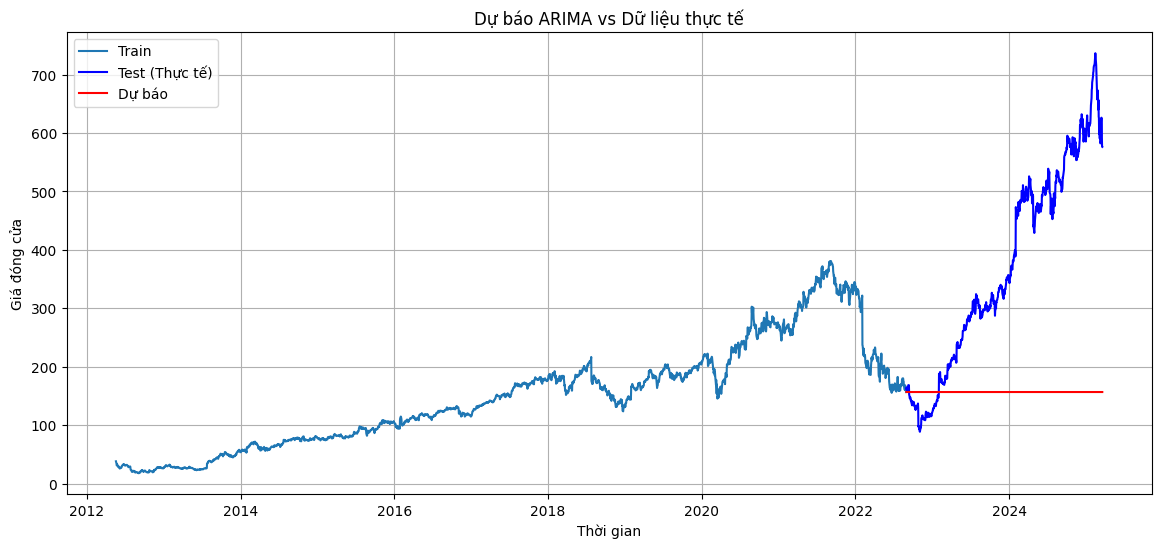

In [56]:
# Dự báo số bước bằng chiều dài test
forecast = model_fit.forecast(steps=len(test))
forecast.index = test.index  # Đảm bảo khớp index với test

print(forecast)

plt.figure(figsize=(14, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test (Thực tế)', color='blue')
plt.plot(forecast, label='Dự báo', color='red')
plt.title('Dự báo ARIMA vs Dữ liệu thực tế')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa')
plt.legend()
plt.grid(True)
plt.show()


In [57]:
r2 = r2_score(forecast,test)
mae = mean_absolute_error(forecast, test)
mse = mean_squared_error(forecast, test)
rmse = np.sqrt(mse)
mape = (np.abs((forecast - test) / test)).mean() * 100

print("\nKết quả đánh giá mô hình ARIMA:")
print(f"R2_score: {r2:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.2f}%")



Kết quả đánh giá mô hình ARIMA:
R2_score: -10731567585.2264
MAE  : 227.8376
MSE  : 77849.9588
RMSE : 279.0161
MAPE : 52.02%


In [ ]:
import pandas as pd

# Đọc file CSV
df = pd.read_csv("ETA.csv")

# Xử lý cột ngày
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Kiểm tra nhanh
df.head()


,Open,High,Low,Close,Volume,Year Quarter
Date,,,,,,
2012-05-18,41.889986,44.828761,37.855398,38.084522,573576400,2012Q2
2012-05-21,36.390988,36.520494,32.874422,33.900501,168192700,2012Q2
2012-05-22,32.485908,33.462179,30.822263,30.882034,101786600,2012Q2
2012-05-23,31.250625,32.376325,31.240663,31.878227,73600000,2012Q2
2012-05-24,32.824611,33.083620,31.649101,32.904305,50237200,2012Q2


In [58]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

data = df['Close'].dropna()
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

In [59]:
# --- Sử dụng auto_arima để chọn mô hình tốt nhất ---
stepwise_model = auto_arima(train,
                            start_p=0, start_q=0,
                            max_p=5, max_q=5,
                            d=None,
                            seasonal=False,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

print(f"\nMô hình ARIMA tối ưu: {stepwise_model.order}")
print(f"AIC: {stepwise_model.aic():.2f}")
print(f"BIC: {stepwise_model.bic():.2f}")


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14640.745, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14635.994, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14636.257, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14639.068, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=14636.723, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14634.391, Time=0.42 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14636.192, Time=1.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14635.441, Time=2.58 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=14637.323, Time=0.47 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=14632.739, Time=1.22 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=14634.618, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=14634.354, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=14634.534, Time=0.86 sec
 ARIMA(1,1,2)(0,0,0)[0]  

In [ ]:
# --- Huấn luyện lại mô hình với thông số tối ưu ---
model = ARIMA(train, order=stepwise_model.order)
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))
forecast.index = test.index


c:\Users\nhiye\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nhiye\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nhiye\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nhiye\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is ava

In [61]:
# --- Đánh giá mô hình ---
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = (np.abs((test - forecast) / test)).mean() * 100

print("\nĐánh giá mô hình ARIMA tối ưu:")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.2f}%")



Đánh giá mô hình ARIMA tối ưu:
MAE  : 227.8376
MSE  : 77849.9588
RMSE : 279.0161
MAPE : 52.02%


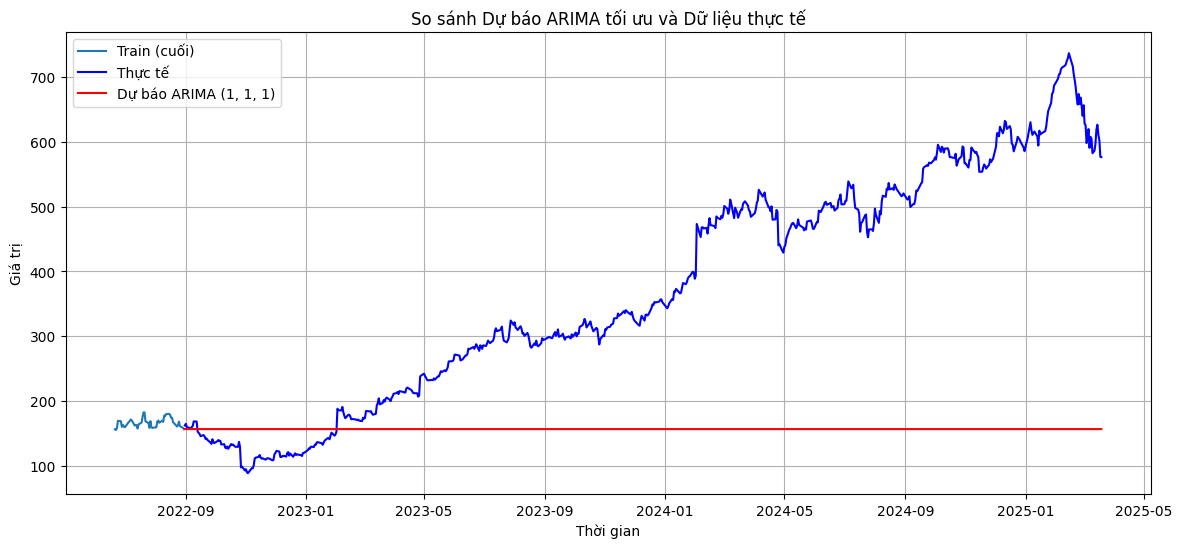

In [62]:
# --- Vẽ biểu đồ dự báo ---
plt.figure(figsize=(14, 6))
plt.plot(train[-50:], label='Train (cuối)')
plt.plot(test, label='Thực tế', color='blue')
plt.plot(forecast, label=f'Dự báo ARIMA {stepwise_model.order}', color='red')
plt.title('So sánh Dự báo ARIMA tối ưu và Dữ liệu thực tế')
plt.xlabel('Thời gian')
plt.ylabel('Giá trị')
plt.legend()
plt.grid(True)
plt.show()